In [1]:
from diffusers import StableDiffusionPipeline, AutoencoderKL, DDIMScheduler
import torch
from transformers import CLIPTokenizer, CLIPTextModel
from PIL import Image
from torchvision import transforms

from tool.show import show

from accelerate import Accelerator
accelerator = Accelerator(mixed_precision="fp16")

from processor.image_processor import process_image

import matplotlib.pyplot as plt


In [2]:
# Cell : 加载 diffusers Pipeline 

vae = AutoencoderKL.from_pretrained("/root/stable-diffusion-2-1-base/vae").to(accelerator.device)
vae = accelerator.prepare(vae)

# 加载扩散模型管道
pipe = StableDiffusionPipeline.from_pretrained("/root/stable-diffusion-2-1-base",
    vae=vae,
    revision="fp16",
    torch_dtype=torch.float16, 
    ).to(accelerator.device)

pipeline = accelerator.prepare(pipe)
pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)




Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [3]:
# Cell : 文本编码部分


# 加载 tokenizer 和 text encoder
tokenizer = CLIPTokenizer.from_pretrained("/root/stable-diffusion-2-1-base/tokenizer")
text_encoder = CLIPTextModel.from_pretrained("/root/stable-diffusion-2-1-base/text_encoder")

# 你的 prompt
prompt = "a image of a seal roaring in the ocean"

# Tokenize & encode
inputs = tokenizer(
    prompt,
    return_tensors="pt",
    padding="max_length",
    max_length=tokenizer.model_max_length,
    truncation=True
)
with torch.no_grad():
    text_embeddings = text_encoder(**inputs).last_hidden_state.to(accelerator.device)

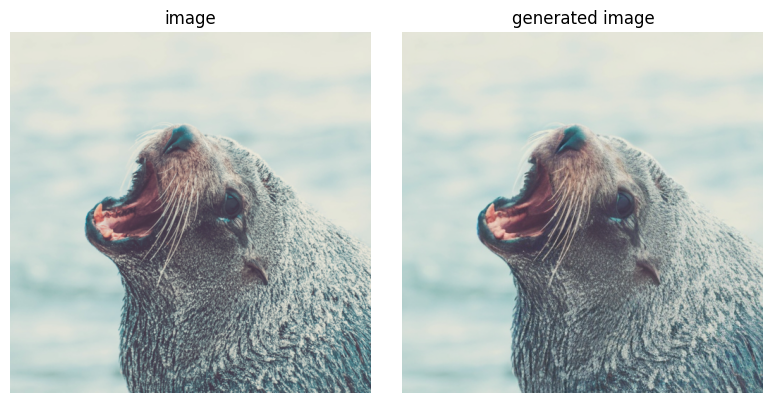

In [ ]:
# read image
image = Image.open("./1.png").convert("RGB")
vae_input = process_image("./1.png").to(accelerator.device)

# 生成LQ的VAE嵌入 vae input should be in the range of [-1, 1]
vae_embedding = pipeline.vae.encode(
    vae_input,
)
begin_latents = vae_embedding[0].mode()  * pipeline.vae.config.scaling_factor

decode_image = pipeline.vae.decode(begin_latents / pipeline.vae.config.scaling_factor).sample
decode_image = pipeline.image_processor.postprocess(decode_image.detach(), output_type="pil", do_denormalize=[True] * decode_image.shape[0])[0]

# 并排显示 begin_image 和 生成的 image
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(image)
axes[0].set_title("image")
axes[0].axis('off')

axes[1].imshow(decode_image)
axes[1].set_title("generated image")
axes[1].axis('off')

plt.tight_layout()
plt.show()

  0%|          | 0/50 [00:00<?, ?it/s]

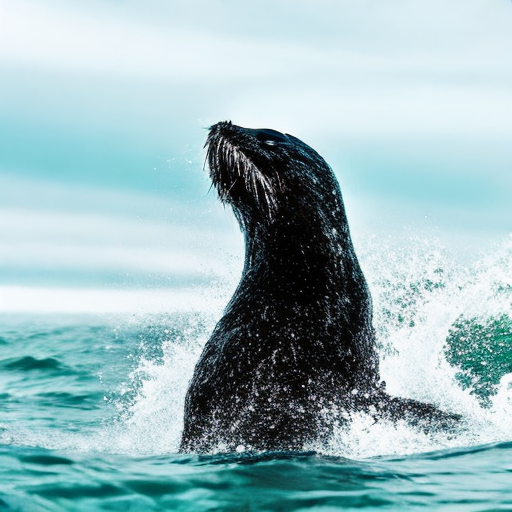

In [7]:
# 设置随机种子
seed = torch.randint( 0, 2**32 - 1, (1,), device=pipe.device).item()
# seed = 114514
# seed = 49408
generator = torch.Generator(device=pipe.device).manual_seed(seed)

# 使用文本编码生成图像
with torch.autocast(pipe.device.type):
    image = pipe(prompt_embeds=text_embeddings, 
                 latents=begin_latents,
                 num_inference_steps=50,
                 guidance_scale=5,
                 generator=generator).images[0]

# 显示图像
image

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

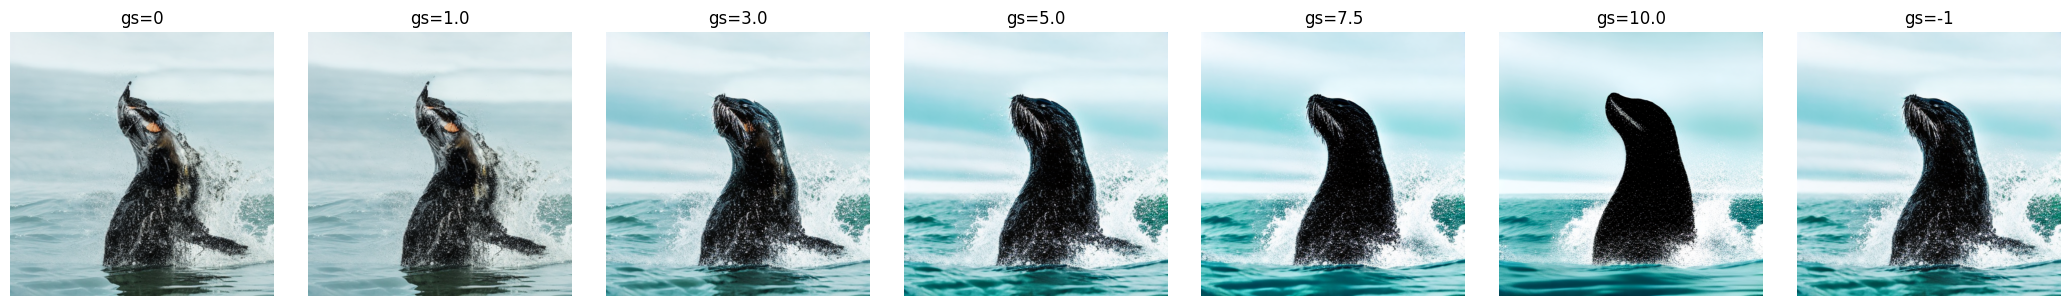

In [8]:
# 在最后一个单元后新增：guidance_scale 调优并排可视化
# Cell: guidance_tuning
guidance_values = [0, 1.0, 3.0, 5.0, 7.5, 10.0]
results = []
with torch.autocast(pipe.device.type):
    for gs in guidance_values:
        # 每次重置相同 seed 保证可比性
        gen = torch.Generator(device=pipe.device).manual_seed(seed)
        out = pipeline(
            num_inference_steps=50,
            guidance_scale=gs,
            prompt_embeds=text_embeddings,
            latents=begin_latents,
            generator=gen
        )
        results.append(out.images[0])

results.append(image)
guidance_values.append(-1)

# 并排显示
plt.figure(figsize=(len(results)*3, 3))
for i, img in enumerate(results):
    plt.subplot(1, len(results), i+1)
    plt.imshow(img)
    plt.title(f"gs={guidance_values[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()